In this project, we are going to utilize the fashion mnist dataset and will be using different flavors of neural networks to come up with potential solution.

In [1]:
# Import necessary libraries
import torch  # Core PyTorch library for tensor operations and deep learning
from torch import nn  # Neural network module

# Import torchvision for datasets and transformations
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose

# Import matplotlib for plotting and visualization
import matplotlib.pyplot as plt

# Import necessary modules
from torch import nn, optim
from timeit import default_timer as timer
#from tqdm.auto import tqdm

# Import summary from torchinfo
from torchinfo import summary

# Check the versions of PyTorch and torchvision
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1
Torchvision version: 0.20.1


In [2]:
import os
import matplotlib.pyplot as plt

def save_plot(filename: str, folder: str = "../figures/modeling_plots"):
    """
    Saves the current matplotlib plot to a specified folder.

    Args:
        filename (str): The name of the file to save the plot as (e.g., "my_plot.png").
        folder (str): The folder where the plot should be saved. Default is "figures/modeling_plots".

    Returns:
        None
    """
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Define the full save path
    save_path = os.path.join(folder, filename)

    # Save the plot
    plt.savefig(save_path, bbox_inches='tight')
    print(f"✅ Figure saved successfully at: {save_path}")


## 1. Gaining familiarity with the dataset

Dataset: FashionMNIST form torchvision.dataset

In [3]:
import os
import pandas as pd

# Define the paths for the CSV files
csv_dir = "../data_preparation"
train_csv_path = os.path.join(csv_dir, "train_data.csv")
validation_csv_path = os.path.join(csv_dir, "validation_data.csv")
test_csv_path = os.path.join(csv_dir, "test_data.csv")

In [4]:
# Load the CSV files into Pandas DataFrames
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(validation_csv_path)
test_df = pd.read_csv(test_csv_path)

# Display the shapes of the DataFrames for confirmation
print(f"Train DataFrame Shape: {train_df.shape}")
print(f"Validation DataFrame Shape: {validation_df.shape}")
print(f"Test DataFrame Shape: {test_df.shape}")

Train DataFrame Shape: (48000, 785)
Validation DataFrame Shape: (12000, 785)
Test DataFrame Shape: (10000, 785)


In [5]:
from torch.utils.data import Dataset

class FashionMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract the label and pixel values
        label = self.dataframe.iloc[idx, 0]
        image = self.dataframe.iloc[idx, 1:].values.astype('float32').reshape(28, 28)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
from torchvision.transforms import ToTensor

# Define transformations (converting images to tensors)
transform = ToTensor()

# Create PyTorch datasets
train_data = FashionMNISTDataset(train_df, transform=transform)
validation_data = FashionMNISTDataset(validation_df, transform=transform)
test_data = FashionMNISTDataset(test_df, transform=transform)

# Display the number of samples in each dataset
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [7]:
# Define the class-to-index mapping (same as Fashion MNIST dataset)
class_to_idx = {
    "T-shirt/top": 0,
    "Trouser": 1,
    "Pullover": 2,
    "Dress": 3,
    "Coat": 4,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 7,
    "Bag": 8,
    "Ankle boot": 9
}

# Create a reverse mapping from index to class name
class_names = {v: k for k, v in class_to_idx.items()}

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label: 1
✅ Figure saved successfully at: ../figures/modeling_plots/first_image_visualization.png


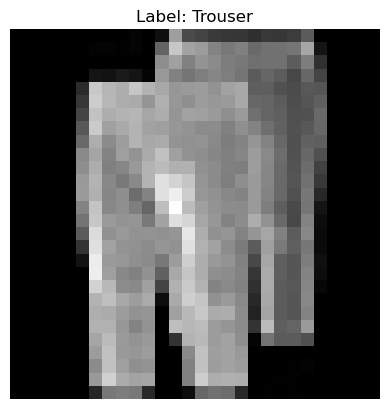

In [8]:
# Access the first image and label from the train dataset
image, label = train_data[0]

# Check the type and shape of the image tensor and label
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Label: {label}")

# Visualize the image using matplotlib
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {class_names[label]}")
plt.axis('off')

# Save the plot using the save_plot() helper function
save_plot("first_image_visualization.png")

# Display the plot
plt.show()

Clearly, the image is in tensor format and the label is an integer. Since, this is a gray scale image, we have a single channel here.

✅ Figure saved successfully at: ../figures/modeling_plots/image_grid.png


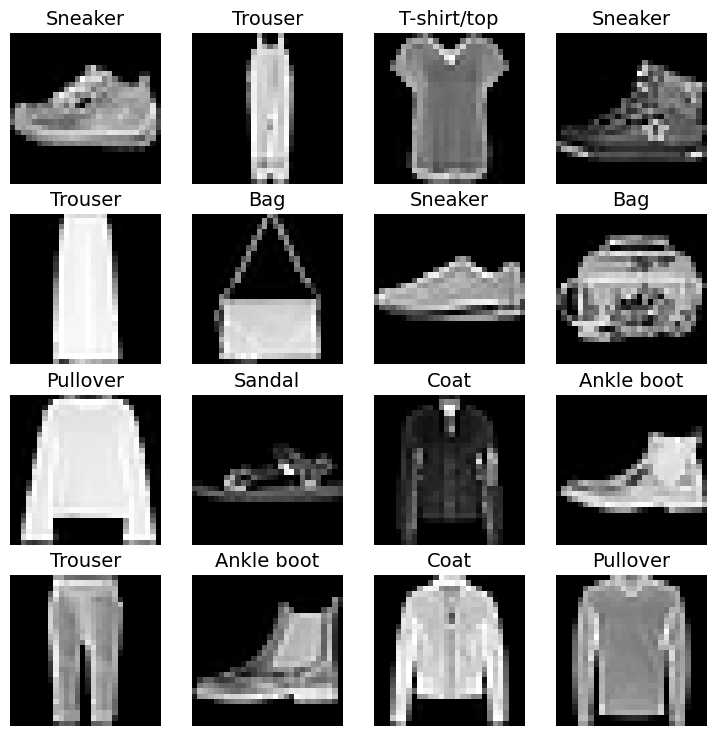

In [9]:
# Plotting an array of images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label], fontsize= 14)
  plt.axis(False) # removes axes

# Save the figure using the helper function
save_plot("image_grid.png")

# Display the plot
plt.show()

As per initial analysis, these items of clothing shoud be modeled with non-linearities and not just pure linear lines.

## 2. Preparing DataLoader

Dataloaders turn our dataset into a Python iterable.

We plan to load our data in batchsize of 32, which is ideal for our dataset. This gives our neural network more chances to update its gradient per epoch.

In [10]:
from torch.utils.data import DataLoader

# Define DataLoaders
BATCH_SIZE = 32

# Train DataLoader
train_dataloader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

# Validation DataLoader
validation_dataloader = DataLoader(validation_data, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False)

# Test DataLoader
test_dataloader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Check DataLoader sizes
print(f"Number of batches in train_loader: {len(train_dataloader)}")
print(f"Number of batches in validation_loader: {len(validation_dataloader)}")
print(f"Number of batches in test_loader: {len(test_dataloader)}")


Number of batches in train_loader: 1500
Number of batches in validation_loader: 375
Number of batches in test_loader: 313


It is generally easier to evaluate a model when the test data is not shuffled. By shuffling the train data, it is not learning any order. The test data is not seen by model during training, so the order does not really matter.

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
✅ Figure saved successfully at: ../figures/modeling_plots/random_image_from_batch.png


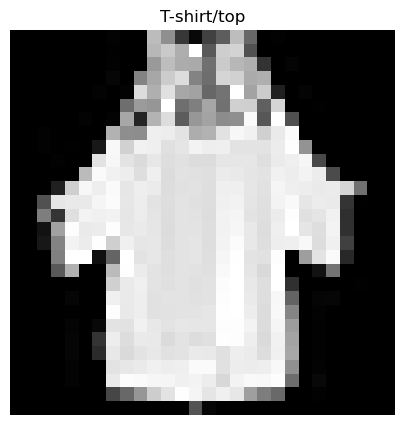

Image size: torch.Size([1, 28, 28])
Label: 0, label size: 1


In [11]:
# Checking out the inside of the training DataLoader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

# Print the shapes of the feature and label batches
print(f"Feature batch shape: {train_features_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

# Set a random seed for reproducibility
torch.manual_seed(42)

# Select a random index from the batch
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

# Get the image and label from the selected random index
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

# Convert the label tensor to an integer
label = label.item()

# Visualize the image
plt.figure(figsize=(5, 5))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis('off')

# Save the plot using the helper function
save_plot("random_image_from_batch.png", folder="../figures/modeling_plots")

# Display the plot
plt.show()

# Print the image and label information
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {len(str(label))}")

## 3. Building Models

We will be building multiple models, perform hyperparameter tuning, select the best model to perform classification

#### 3.1 Mini CNN Architecture

In [12]:
import torch
from torch import nn

class MiniCNN(nn.Module):
    """
    A simple, lightweight CNN model for baseline performance on Fashion MNIST.
    """

    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32 * 7 * 7, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [13]:
# Printing the summary of the MiniCNN model
input_size = (1, 1, 28, 28)

mini_cnn = MiniCNN(in_channels=1, num_classes=10)
print("MiniCNN Summary:")
print(summary(mini_cnn, input_size=input_size))


MiniCNN Summary:
Layer (type:depth-idx)                   Output Shape              Param #
MiniCNN                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           160
│    └─ReLU: 2-2                         [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 16, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 32, 14, 14]           4,640
│    └─ReLU: 2-5                         [1, 32, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 32, 7, 7]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-7                      [1, 1568]                 --
│    └─Linear: 2-8                       [1, 64]                   100,416
│    └─ReLU: 2-9                         [1, 64]                   --
│    └─Linear: 2-10                      [1, 10]           

#### 3.2 Tiny VGG Architecture

In [14]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    """
    TinyVGG model architecture for image classification.
    """

    def __init__(self, in_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [15]:
# Printing the summary of the TinyVGG model
tiny_vgg = TinyVGG(in_channels=1, hidden_units=64, output_shape=10)
print("\nTinyVGG Summary:")
print(summary(tiny_vgg, input_size=input_size))


TinyVGG Summary:
Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
├─Sequential: 1-2                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 64, 14, 14]           36,928
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 64, 14, 14]           36,928
│    └─ReLU: 2-9                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 64, 7, 7]

#### 3.3 Resnet Architecture

In [16]:
import torch
from torch import nn

# Define the Basic Block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        # Apply the convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Apply downsample if needed
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Add the residual connection
        x += identity
        return self.relu(x)


# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64

        # Stem of the network
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Adaptive pooling and classifier
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        # Check if downsample is needed
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        # Add the first block with downsample (if necessary)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        # Add subsequent blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Forward pass through the residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Adaptive pooling and flatten
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)

        # Classifier
        return self.classifier(x)


# Function to create a ResNet model
def create_resnet(num_classes=10, layers=[2, 2, 2, 2]):
    """
    Constructs a ResNet model.
    num_classes: Number of output classes (default is 10 for Fashion MNIST).
    layers: List defining the number of blocks in each layer.
            [2, 2, 2, 2] corresponds to ResNet18-like architecture.
    """
    return ResNet(BasicBlock, layers, num_classes)

In [17]:
# Printing the summary of the ResNet-18 model
resnet = create_resnet(num_classes=10, layers=[2, 2, 2, 2])  # ResNet-18
print("\nResNet Summary:")
print(summary(resnet, input_size=input_size))


ResNet Summary:
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 28, 28]           576
├─BatchNorm2d: 1-2                       [1, 64, 28, 28]           128
├─ReLU: 1-3                              [1, 64, 28, 28]           --
├─MaxPool2d: 1-4                         [1, 64, 14, 14]           --
├─Sequential: 1-5                        [1, 64, 14, 14]           --
│    └─BasicBlock: 2-1                   [1, 64, 14, 14]           --
│    │    └─Conv2d: 3-1                  [1, 64, 14, 14]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 14, 14]           128
│    │    └─ReLU: 3-3                    [1, 64, 14, 14]           --
│    │    └─Conv2d: 3-4                  [1, 64, 14, 14]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 14, 14]           128
│    │    └─ReLU: 3-6                    [1, 64, 14, 14]

## 4. Making Device Agnostic code, Evaluation Metrics




In [18]:
# Device agnostic code for CPU, MPS (Apple GPU), and CUDA (NVIDIA GPU)
# Check for available device (CPU, CUDA, or MPS for Apple Silicon)
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## 5. Training and Evaluation Functions

In [19]:
from typing import Tuple

# train step function - for training model
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [20]:
from typing import Tuple

# validation step function - for validating the model
def validation_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> Tuple[float, float]:
    """
    Validates a PyTorch model for a single epoch.

    Puts the model in evaluation mode and performs a forward pass on the validation dataset.

    Args:
        model: A PyTorch model to be validated.
        dataloader: A DataLoader instance for the validation data.
        loss_fn: A PyTorch loss function to calculate loss on the validation data.
        device: A target device to compute on (e.g., "cuda" or "cpu").

    Returns:
        A tuple of validation loss and validation accuracy metrics.
        In the form (val_loss, val_accuracy).
    """
    # Put model in eval mode
    model.eval()

    # Initialize validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            val_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = torch.softmax(val_pred_logits, dim=1).argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

    # Calculate average loss and accuracy
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    return val_loss, val_acc


In [21]:
# test step function - for testing model
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.softmax(test_pred_logits, dim=1).argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [22]:
from typing import Dict, List
from tqdm.auto import tqdm

def train_with_early_stopping(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    patience: int = 2,
    min_delta: float = 0.001
) -> Tuple[Dict[str, List[float]], Dict[str, float]]:
    """
    Trains a PyTorch model with early stopping and records test metrics at each epoch.

    Args:
        model: A PyTorch model to be trained.
        train_dataloader: DataLoader for the training data.
        val_dataloader: DataLoader for the validation data.
        test_dataloader: DataLoader for the test data.
        optimizer: Optimizer for minimizing the loss.
        loss_fn: Loss function to use.
        epochs: Maximum number of epochs for training.
        device: Device for computations (e.g., "cuda" or "cpu").
        patience: Number of epochs to wait for improvement before stopping.
        min_delta: Minimum change in validation loss to qualify as an improvement.

    Returns:
        A tuple containing:
        - A dictionary of training, validation, and testing metrics.
        - The best model weights (state_dict).
    """
    # Initialize results dictionary
    results = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": [],
        "test_loss": [], "test_acc": []
    }

    # Initialize early stopping variables
    best_val_loss = float('inf')
    counter = 0
    best_model_weights = model.state_dict()

    # Loop through epochs
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Validation step
        val_loss, val_acc = validation_step(model, val_dataloader, loss_fn, device)

        # Testing step
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        # Print epoch metrics
        print(
            f"Epoch: {epoch + 1} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}"
        )

        # Store metrics
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            counter = 0
            print("✅ Improvement in validation loss. Best model weights updated.")
        else:
            counter += 1
            print(f"No improvement in validation loss. Early stopping counter: {counter}/{patience}")

        # Check if early stopping should be triggered
        if counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch + 1}.")
            break

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    return results, best_model_weights

## 6. Trying different models

In [23]:
import os

def save_best_model(model, model_name, save_dir="../models/all_models"):
    """
    Saves the best model and its weights.

    Args:
        model: A PyTorch model to be saved.
        model_name: Name of the model (e.g., "MiniCNN").
        save_dir: Directory to save the model and weights.
    """
    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Define file paths
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    weights_path = os.path.join(save_dir, f"{model_name}_weights.pth")

    # Save the entire model and its state dictionary
    torch.save(model, model_path)
    torch.save(model.state_dict(), weights_path)

    print(f"✅ {model_name} saved to: {model_path}")
    print(f"Weights saved to: {weights_path}")

In [24]:
# Import necessary modules
import torch
from torch import nn, optim
from timeit import default_timer as timer

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Set the number of epochs
NUM_EPOCHS = 10

# Set the number of classes
NUM_CLASSES = 10

# Initialize a dictionary to store results for each model
all_results = {}

# Define a function to train and save models with early stopping
def train_and_save_model_with_early_stopping(
    model,
    model_name,
    optimizer,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    patience=2,
    min_delta=0.001
):
    """
    Trains the model with early stopping and saves the best model.
    """
    # Send the model to the device
    model.to(device)

    # Start the timer
    start_time = timer()

    # Train with early stopping
    results, best_model_weights = train_with_early_stopping(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader= test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
        device=device,
        patience=patience,
        min_delta=min_delta
    )

    # End the timer
    end_time = timer()
    print(f"\n[INFO] Total training time for {model_name}: {end_time - start_time:.3f} seconds")
    print(f"✅ {model_name} training complete.")

    # Load the best model weights before saving
    model.load_state_dict(best_model_weights)
    
    # Save the best model
    save_best_model(model, model_name)

     # Store the results
    all_results[model_name] = results

    # Print the final metrics
    print(f"Final training accuracy for {model_name}: {results['train_acc'][-1]:.4f}")
    print(f"Final validation accuracy for {model_name}: {results['val_acc'][-1]:.4f}")
    print(f"Final testing accuracy for {model_name}: {results['test_acc'][-1]:.4f}")

#### 6.1 Mini CNN training

In [25]:
mini_cnn_model = MiniCNN(in_channels=1, num_classes=NUM_CLASSES)
optimizer_mini_cnn = optim.Adam(mini_cnn_model.parameters(), lr=0.001)
train_and_save_model_with_early_stopping(
    model=mini_cnn_model,
    model_name="mini_cnn_model",
    optimizer=optimizer_mini_cnn,
    train_dataloader=train_dataloader,
    val_dataloader=validation_dataloader,
    test_dataloader=test_dataloader
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.5302 | Train Acc: 0.8060 | Val Loss: 0.3624 | Val Acc: 0.8658 | Test Loss: 0.3885 | Test Acc: 0.8610
✅ Improvement in validation loss. Best model weights updated.
Epoch: 2 | Train Loss: 0.3447 | Train Acc: 0.8747 | Val Loss: 0.3249 | Val Acc: 0.8814 | Test Loss: 0.3494 | Test Acc: 0.8733
✅ Improvement in validation loss. Best model weights updated.
Epoch: 3 | Train Loss: 0.2986 | Train Acc: 0.8907 | Val Loss: 0.2808 | Val Acc: 0.8962 | Test Loss: 0.3103 | Test Acc: 0.8853
✅ Improvement in validation loss. Best model weights updated.
Epoch: 4 | Train Loss: 0.2656 | Train Acc: 0.9026 | Val Loss: 0.2823 | Val Acc: 0.8950 | Test Loss: 0.3168 | Test Acc: 0.8864
No improvement in validation loss. Early stopping counter: 1/2
Epoch: 5 | Train Loss: 0.2419 | Train Acc: 0.9116 | Val Loss: 0.2454 | Val Acc: 0.9100 | Test Loss: 0.2767 | Test Acc: 0.9006
✅ Improvement in validation loss. Best model weights updated.
Epoch: 6 | Train Loss: 0.2249 | Train Acc: 0.9181 | Val Los

#### 6.2 Tiny VGG

In [26]:
tiny_vgg_model = TinyVGG(in_channels=1, hidden_units=20, output_shape=NUM_CLASSES)
optimizer_tiny_vgg = optim.Adam(tiny_vgg_model.parameters(), lr=0.001)
train_and_save_model_with_early_stopping(
    model=tiny_vgg_model,
    model_name="tiny_vgg_model",
    optimizer=optimizer_tiny_vgg,
    train_dataloader=train_dataloader,
    val_dataloader=validation_dataloader,
    test_dataloader=test_dataloader
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.5274 | Train Acc: 0.8077 | Val Loss: 0.3360 | Val Acc: 0.8788 | Test Loss: 0.3716 | Test Acc: 0.8674
✅ Improvement in validation loss. Best model weights updated.
Epoch: 2 | Train Loss: 0.3330 | Train Acc: 0.8818 | Val Loss: 0.3118 | Val Acc: 0.8898 | Test Loss: 0.3412 | Test Acc: 0.8774
✅ Improvement in validation loss. Best model weights updated.
Epoch: 3 | Train Loss: 0.2900 | Train Acc: 0.8964 | Val Loss: 0.2667 | Val Acc: 0.9056 | Test Loss: 0.2967 | Test Acc: 0.8931
✅ Improvement in validation loss. Best model weights updated.
Epoch: 4 | Train Loss: 0.2595 | Train Acc: 0.9073 | Val Loss: 0.2678 | Val Acc: 0.9044 | Test Loss: 0.2969 | Test Acc: 0.8974
No improvement in validation loss. Early stopping counter: 1/2
Epoch: 5 | Train Loss: 0.2387 | Train Acc: 0.9141 | Val Loss: 0.2406 | Val Acc: 0.9115 | Test Loss: 0.2678 | Test Acc: 0.9057
✅ Improvement in validation loss. Best model weights updated.
Epoch: 6 | Train Loss: 0.2210 | Train Acc: 0.9191 | Val Los

#### 6.3 ResNet

In [27]:
# Train ResNet
resnet_model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES)
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
train_and_save_model_with_early_stopping(
    model=resnet_model,
    model_name="resnet_model",
    optimizer=optimizer_resnet,
    train_dataloader=train_dataloader,
    val_dataloader=validation_dataloader,
    test_dataloader=test_dataloader
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.4027 | Train Acc: 0.8528 | Val Loss: 0.2939 | Val Acc: 0.8888 | Test Loss: 0.3113 | Test Acc: 0.8845
✅ Improvement in validation loss. Best model weights updated.
Epoch: 2 | Train Loss: 0.2655 | Train Acc: 0.9032 | Val Loss: 0.2416 | Val Acc: 0.9144 | Test Loss: 0.2577 | Test Acc: 0.9089
✅ Improvement in validation loss. Best model weights updated.
Epoch: 3 | Train Loss: 0.2261 | Train Acc: 0.9159 | Val Loss: 0.2430 | Val Acc: 0.9133 | Test Loss: 0.2665 | Test Acc: 0.9053
No improvement in validation loss. Early stopping counter: 1/2
Epoch: 4 | Train Loss: 0.1970 | Train Acc: 0.9274 | Val Loss: 0.2200 | Val Acc: 0.9197 | Test Loss: 0.2451 | Test Acc: 0.9113
✅ Improvement in validation loss. Best model weights updated.
Epoch: 5 | Train Loss: 0.1691 | Train Acc: 0.9370 | Val Loss: 0.2251 | Val Acc: 0.9182 | Test Loss: 0.2421 | Test Acc: 0.9099
No improvement in validation loss. Early stopping counter: 1/2
Epoch: 6 | Train Loss: 0.1420 | Train Acc: 0.9478 | Val Lo

#### 6.4 Printing Summary of all the models

In [28]:
# Print summary of all results
print("\n[INFO] Training completed for all models.")
for model_name, results in all_results.items():
    print(f"\nResults for {model_name}:")
    print(f"Training Accuracy: {results['train_acc'][-1]:.4f}")
    print(f"Validation Accuracy: {results['val_acc'][-1]:.4f}")
    print(f"Testing Accuracy: {results['test_acc'][-1]:.4f}")


[INFO] Training completed for all models.

Results for mini_cnn_model:
Training Accuracy: 0.9333
Validation Accuracy: 0.9100
Testing Accuracy: 0.9034

Results for tiny_vgg_model:
Training Accuracy: 0.9257
Validation Accuracy: 0.9078
Testing Accuracy: 0.9015

Results for resnet_model:
Training Accuracy: 0.9478
Validation Accuracy: 0.9143
Testing Accuracy: 0.9093


## 7. Performance Analysis and Plots

In [29]:
import matplotlib.pyplot as plt
import os

def plot_metrics(metrics: dict, model_name: str, save_dir: str = "../figures/modeling_plots"):
    """
    Plots and saves training, validation, and test metrics for a model.

    Args:
        metrics (dict): Dictionary containing the metrics (train_loss, val_loss, test_loss, train_acc, val_acc, test_acc).
        model_name (str): Name of the model (e.g., "MiniCNN", "TinyVGG", "ResNet").
        save_dir (str): Directory to save the plots.
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Set up the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Losses (Training, Validation, Test)
    axs[0].plot(metrics['train_loss'], label='Training Loss', marker='o', linestyle='--')
    axs[0].plot(metrics['val_loss'], label='Validation Loss', marker='x', linestyle='-.')
    axs[0].plot(metrics['test_loss'], label='Test Loss', marker='s', linestyle=':')
    axs[0].set_title(f'{model_name} - Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Accuracies (Training, Validation, Test)
    axs[1].plot(metrics['train_acc'], label='Training Accuracy', marker='o', linestyle='--')
    axs[1].plot(metrics['val_acc'], label='Validation Accuracy', marker='x', linestyle='-.')
    axs[1].plot(metrics['test_acc'], label='Test Accuracy', marker='s', linestyle=':')
    axs[1].set_title(f'{model_name} - Accuracy vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid()

    # Adjust layout for better visibility
    plt.suptitle(f'{model_name} - Training, Validation, and Test Metrics', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save the combined plot
    plot_path = os.path.join(save_dir, f"{model_name}_metrics_plot.png")
    plt.savefig(plot_path)
    print(f"✅ Metrics plot saved to: {plot_path}")
    plt.show()

#### 7.1 Mini CNN

✅ Metrics plot saved to: ../figures/modeling_plots/MiniCNN_metrics_plot.png


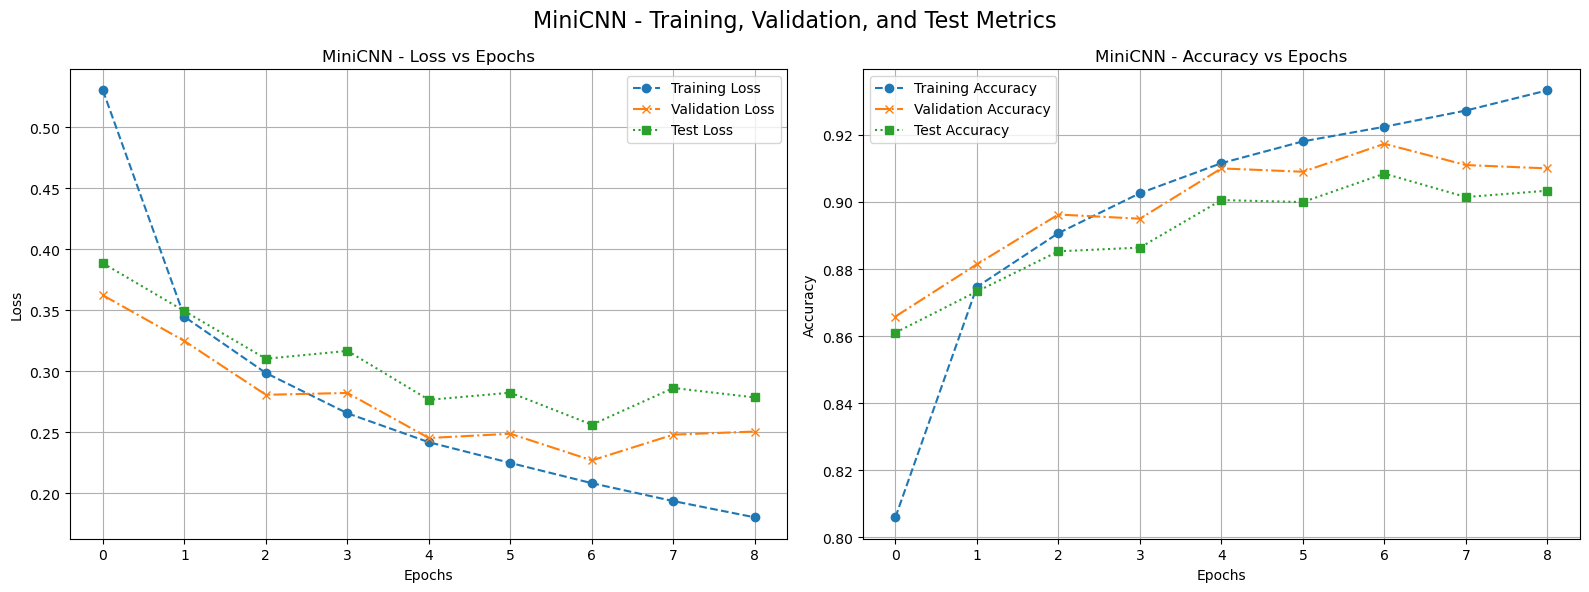

In [30]:
# MiniCNN
results_mini_cnn= all_results['mini_cnn_model']
plot_metrics(metrics=results_mini_cnn, model_name="MiniCNN")

### MiniCNN Model Observations

- **Training Loss & Accuracy**: Consistent decrease in loss and increase in accuracy, indicating effective learning throughout the epochs.
- **Validation Metrics**: Validation loss and accuracy stabilize after epoch 4, suggesting overfitting beyond this point.
- **Test Metrics**: Test loss and accuracy mirror validation trends, indicating good generalization but slightly lower performance than validation.
- **Recommendation**: Early stopping around epoch 4-5 would prevent overfitting and improve efficiency.

#### 7.2 Tiny VGG

✅ Metrics plot saved to: ../figures/modeling_plots/TinyVGG_metrics_plot.png


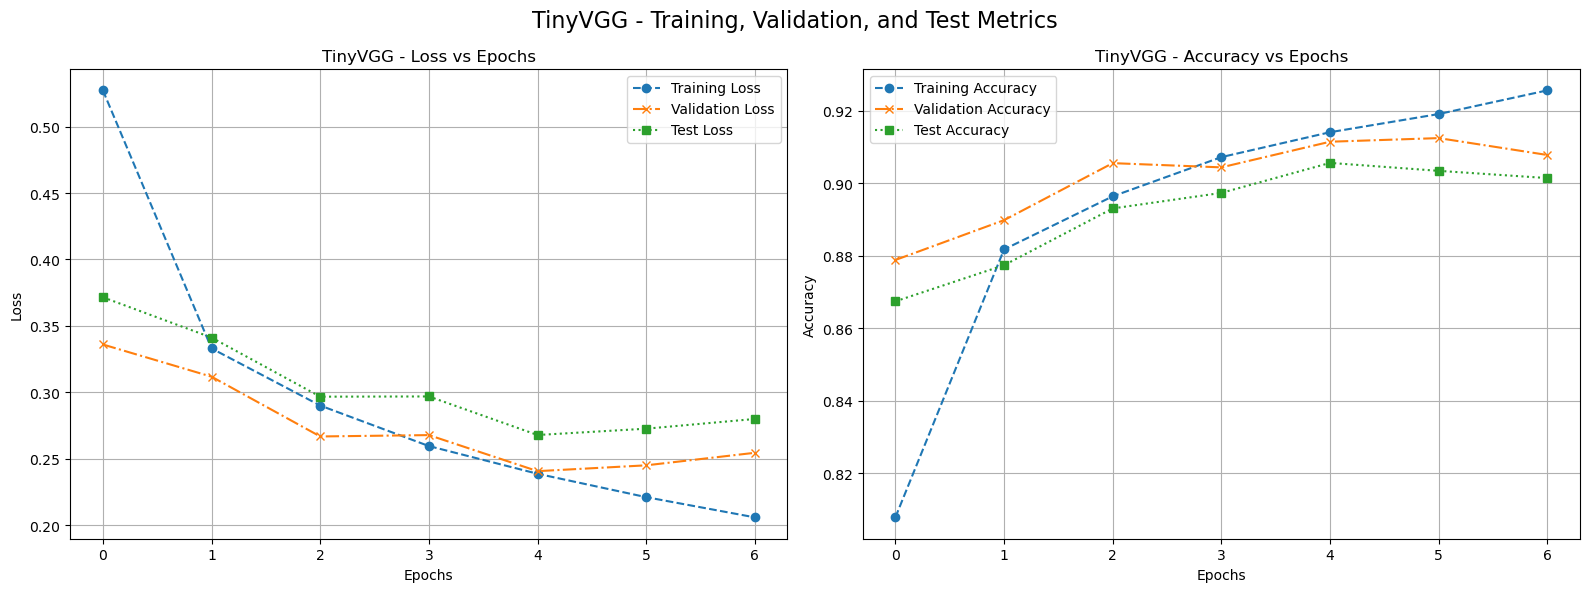

In [31]:
# TinyVGG
results_tiny_vgg = all_results['tiny_vgg_model']
plot_metrics(metrics=results_tiny_vgg, model_name="TinyVGG")

### TinyVGG Model Observations

- **Training Loss & Accuracy**: Smooth decrease in loss and increase in accuracy, showing stable learning. The model continues to improve across epochs.
- **Validation Metrics**: Validation loss reduces until epoch 4, after which it flattens, indicating potential overfitting beyond this point.
- **Test Metrics**: Test accuracy follows the trend of validation accuracy, but slightly underperforms, suggesting a slight gap in generalization.
- **Recommendation**: Early stopping around epoch 4-5 would be beneficial to avoid overfitting and save computational time.

#### 7.3 ResNet

✅ Metrics plot saved to: ../figures/modeling_plots/ResNet_metrics_plot.png


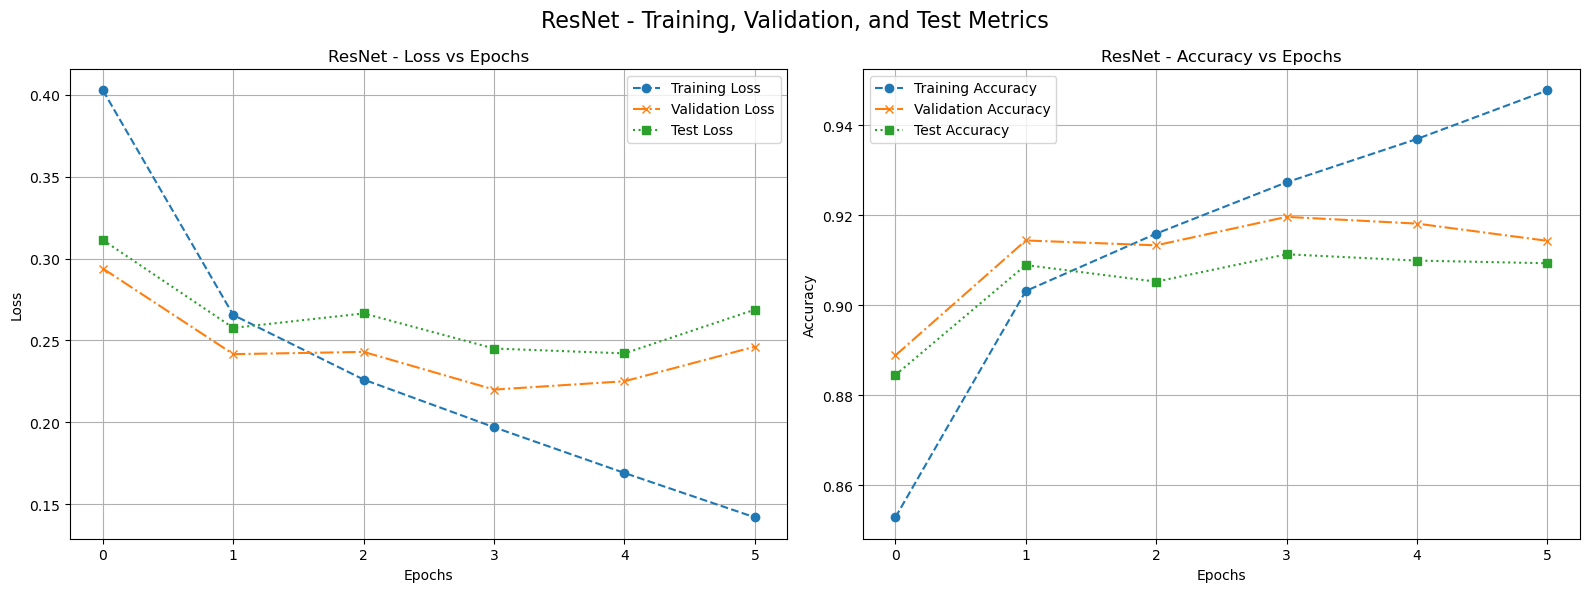

In [32]:
# ResNet
results_resnet= all_results['resnet_model']
plot_metrics(metrics=results_resnet, model_name="ResNet")

### ResNet Model Observations

- **Training Loss & Accuracy**: Training loss decreases consistently across epochs, and accuracy improves steadily, indicating good learning progress.
- **Validation Metrics**: Validation loss reduces up to epoch 2, after which it stabilizes and slightly increases, suggesting the onset of overfitting.
- **Test Metrics**: Test accuracy closely follows the validation trend but slightly underperforms, showing a similar pattern of generalization.
- **Recommendation**: Early stopping at epoch 3 would be advisable as there is no significant improvement beyond this point, and it helps prevent overfitting.